# Tableau uploads

## Imports

In [1]:
import pandas as pd
import numpy as np
import wrangle as w
import explore as e
pd.set_option('display.max_columns', None)

In [2]:
df = w.clean_311(w.get_311_data())

In [ ]:
error = df[df.days_before_or_after_due == -1]

In [ ]:
error.level_of_delay.value_counts()

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.level_of_delay.value_counts()

In [ ]:
df.is_late.value_counts()

In [ ]:
df.days_before_or_after_due.value_counts()

In [ ]:
on_time = df[df.level_of_delay == 'On Time Response']
very_late = df[df.level_of_delay == 'Very Late Response']
early = df[df.level_of_delay == 'Early Response']

In [ ]:
on_time.days_before_or_after_due.value_counts()

In [ ]:
very_late.days_before_or_after_due.value_counts()

In [ ]:
early.days_before_or_after_due.value_counts()

In [ ]:
df[df.days_before_or_after_due < 0]

In [3]:
def get_late(days_before_or_after_due):
    if days_before_or_after_due < 0:
        return 'late'
    else:
        return 'on time'
        

In [4]:
#get actual amount of late cases
df['late'] = df['days_before_or_after_due'].apply(get_late)

In [5]:
df.to_csv('final2_311.csv')

In [ ]:
# create new feature to show how long it took to resolve compared to resolution due date
#df['days_before_or_after_due'] = df.resolution_days_due - df.days_open

In [ ]:
import model as m

In [ ]:
df = m.model_df()

In [ ]:
  
import pandas as pd
import numpy as np
import wrangle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing

#-----------------------------------------------------------------------------

# Model Prep

def dummy_dept(df):
    # dummy dept feature
    dummy_df =  pd.get_dummies(df['dept'])
    # Name the new columns
    dummy_df.columns = ['animal_care_services', 'code_enforcement_services', 
                        'customer_services', 'development_services', 
                        'metro_health', 'parks_and_rec',
                        'solid_waste_management', 'trans_and_cap_improvements', 
                        'unknown_dept']
    # add the dummies to the data frame
    df = pd.concat([df, dummy_df], axis=1)
    return df
#-----------------------------------------------------------------------------    
def dummy_call_reason(df):
    # dummy dept feature
    dummy_df =  pd.get_dummies(df['call_reason'])
    # Name the new columns
    dummy_df.columns = ['buildings', 'business', 'cleanup', 'code',
                        'customer_service', 'field', 'land',
                        'license', 'misc', 'storm', 'streets', 'trades', 
                        'traffic', 'waste']
    # add the dummies to the data frame
    df = pd.concat([df, dummy_df], axis=1)
    return df
#-----------------------------------------------------------------------------
def make_source_id_dummies(df):
    '''This function takes in the cleaned dataframe, makes dummy variables of the source id column, readds the names of the
    dummy columns and returns the concatenated dummy dataframe to the original dataframe.'''
    #make dummies
    dummy_df = pd.get_dummies(df['source_id'])
    #add back column names
    dummy_df.columns = ['web_portal', '311_mobile_app', 'constituent_call', 'internal_services_requests']
    # concatenate dummies to the cleaned data frame
    df = pd.concat([df, dummy_df], axis=1)
    return df

#-------------------------------
def keep_info(df):
    df.drop(df.columns.difference(['days_before_after_due','dept','call_reason', 'source_id', 'level_of_delay',
                                   'council_district', 'resolution_days_due', 'district_0', 'district_1', 'district_2',
                                   'district_3', 'district_4','district_5', 'district_6', 'district_7', 'district_8', 
                                   'district_9','district_10']), 1, inplace=True)
    return df

#--------------------------------
def model_df():
    '''This function reads in the clean 311 dataframe, applies all of the above functions to prepare it for modeling. 
    The function then returns a cleaned dataframe ready for modeling.'''
    df= wrangle.clean_311(wrangle.get_311_data())
    df= keep_info(df)
    df= dummy_dept(df)
    df= dummy_call_reason(df)
    df= make_source_id_dummies(df)

    return df
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

def split(df, stratify_by= 'level_of_delay'):
    """
    Crude train, validate, test split
    To stratify, send in a column name
    """
    if stratify_by == None:
        train, test = train_test_split(df, test_size=.2, random_state=319)
        train, validate = train_test_split(train, test_size=.3, random_state=319)
    else:
        train, test = train_test_split(df, test_size=.2, random_state=319, stratify=df[stratify_by])
        train, validate = train_test_split(train, test_size=.3, random_state=319, stratify=train[stratify_by])
    return train, validate, test


#------------------------------------
def separate_y(train, validate, test):
    '''
    This function will take the train, validate, and test dataframes and separate the target variable into its
    own panda series
    '''
    
    X_train = train.drop(columns=['level_of_delay'])
    y_train = train.level_of_delay
    X_validate = validate.drop(columns=['level_of_delay'])
    y_validate = validate.level_of_delay
    X_test = test.drop(columns=['level_of_delay'])
    y_test = test.level_of_delay
    return X_train, y_train, X_validate, y_validate, X_test, y_test
#------------------------------------
def scale_data(X_train, X_validate, X_test):
    '''
    This function will scale numeric data using Min Max transform after 
    it has already been split into train, validate, and test.
    '''
    
    
    obj_col = ['dept', 'call_reason','source_id']
    num_train = X_train.drop(columns = obj_col)
    num_validate = X_validate.drop(columns = obj_col)
    num_test = X_test.drop(columns = obj_col)
    
    
    # Make the thing
    scaler = preprocessing.MinMaxScaler()
    
   
    # we only .fit on the training data
    scaler.fit(num_train)
    train_scaled = scaler.transform(num_train)
    validate_scaled = scaler.transform(num_validate)
    test_scaled = scaler.transform(num_test)
    
    # turn the numpy arrays into dataframes
    train_scaled = pd.DataFrame(train_scaled, columns=num_train.columns)
    validate_scaled = pd.DataFrame(validate_scaled, columns=num_train.columns)
    test_scaled = pd.DataFrame(test_scaled, columns=num_train.columns)
    
    
    return train_scaled, validate_scaled, test_scaled

#------------------------------------

def split_separate_scale(df, stratify_by= 'level_of_delay'):
    '''
    This function will take in a dataframe
    separate the dataframe into train, validate, and test dataframes
    separate the target variable from train, validate and test
    then it will scale the numeric variables in train, validate, and test
    finally it will return all dataframes individually
    '''
    
    # split data into train, validate, test
    train, validate, test = split(df, stratify_by= 'level_of_delay')
    
     # seperate target variable
    X_train, y_train, X_validate, y_validate, X_test, y_test = separate_y(train, validate, test)
    
    
    # scale numeric variable
    train_scaled, validate_scaled, test_scaled = scale_data(X_train, X_validate, X_test)
    
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test, train_scaled, validate_scaled, test_scaled

In [ ]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test, train_scaled, validate_scaled, test_scaled = split_separate_scale(df, stratify_by= 'level_of_delay')

In [ ]:
train.head()

In [ ]:
train = train.drop(columns = ['dept', 'call_reason', 
        'source_id', 'council_district'])

In [ ]:
train = train.drop(columns = 'level_of_delay')

In [ ]:
df.head()

In [ ]:
df.late.value_counts()

### Level of Delay by District

https://public.tableau.com/app/profile/lori.segovia/viz/LevelofDelaybyDistrict/District1

In [ ]:
#df.to_csv('all_311.csv')

In [8]:
# 1 and 5 downtown/central
central = df[(df.district_1 == 1) | (df.district_5 == 1)]
# 8 and 9
north = df[(df.district_8 == 1) | (df.district_9 == 1)]
# 4 and 3
south = df[(df.district_4 == 1) | (df.district_3 == 1)]
# 10 and 2
east = df[(df.district_10 == 1) | (df.district_2 == 1)]
#6 and 7
west = df[(df.district_6 == 1) | (df.district_7 == 1)]

In [ ]:
#north = df[(df.council_district == 8) | (df.council_district == 9)]

In [ ]:
#north.head()

In [ ]:
north.council_district.value_counts()

In [12]:
avg_days_north = north.days_before_or_after_due.mean()

In [13]:
avg_days_south = south.days_before_or_after_due.mean()

In [14]:
avg_days_east = east.days_before_or_after_due.mean()

In [15]:
avg_days_west = west.days_before_or_after_due.mean()

In [16]:
avg_days_central = central.days_before_or_after_due.mean()

In [9]:
import scipy.stats as stats

In [10]:
null = 'there is no difference in the means'
alt = 'there is a difference in the means'

In [18]:
print(avg_days_north, 'north')
print(avg_days_south, 'south')
print(avg_days_east, 'east')
print(avg_days_west, 'west')
print(avg_days_central, 'central')

8.872594490711082 north
4.978170052932353 south
4.18188692035929 east
7.958870137567458 west
14.076052300885875 central


#### north statistical tests

In [11]:
# north and south
t, p = stats.ttest_ind(north.days_before_or_after_due, south.days_before_or_after_due)
t, p

(6.857762505880725, 7.028488589933374e-12)

In [21]:
# north and east
t, p = stats.ttest_ind(north.days_before_or_after_due, east.days_before_or_after_due)
t, p

(8.022106395411587, 1.0490977398996743e-15)

In [22]:
# north and west
t, p = stats.ttest_ind(north.days_before_or_after_due, west.days_before_or_after_due)
t, p

(1.5832575909418332, 0.11336583091735253)

In [23]:
# north and central
t, p = stats.ttest_ind(north.days_before_or_after_due, central.days_before_or_after_due)
t, p

(-9.386685536146885, 6.2832508988218854e-21)

#### south statistical tests

In [19]:
# south and east
t, p = stats.ttest_ind(east.days_before_or_after_due, south.days_before_or_after_due)
t, p

(-1.6280672811269723, 0.10351262206713681)

In [24]:
# south and west
t, p = stats.ttest_ind(west.days_before_or_after_due, south.days_before_or_after_due)
t, p

(5.96809144442003, 2.4060042517140513e-09)

In [25]:
# south and central
t, p = stats.ttest_ind(central.days_before_or_after_due, south.days_before_or_after_due)
t, p

(19.974145600931305, 1.1585699322880426e-88)

#### east statistical tests

In [20]:
# east and west
t, p = stats.ttest_ind(east.days_before_or_after_due, west.days_before_or_after_due)
t, p

(-7.3509845898535895, 1.9781208221662076e-13)

In [26]:
# east and central
t, p = stats.ttest_ind(east.days_before_or_after_due, central.days_before_or_after_due)
t, p

(-21.128323774383734, 5.830105513598658e-99)

#### west statistical tests

In [27]:
# west and central
t, p = stats.ttest_ind(central.days_before_or_after_due, west.days_before_or_after_due)
t, p

(12.711917980739397, 5.290778191232789e-37)

In [29]:
import seaborn as sns

<AxesSubplot:xlabel='days_before_or_after_due', ylabel='Density'>

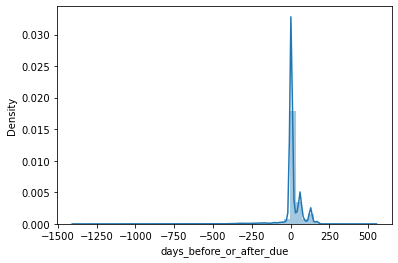

In [30]:
sns.distplot(df.days_before_or_after_due)